First we need to import a few modules: numpy, matplotlib, and h5py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
# make graphics inline
%matplotlib inline

Define the I/O parameters

In [2]:
inDir = '../../data/d1/'
outFile = 'e1.cxi'

and the general parameters of the experiment

In [3]:
energy     = 8000*1.60217657e-19 # 8 keV in J
pixel_size      =  55 * 1e-6 # 55 um pixels
real_pixel_size =  5.5 * 1e-9 # real space pixel size in m

wavelength = 1.98644e-25/energy

Load the probe file:

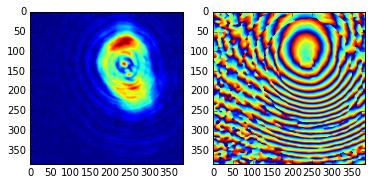

In [4]:
probeFile  = inDir + 'probe.npy'
probe = np.load(probeFile) # (384, 384)

plt.subplot(1,2,1)
plt.imshow(abs(probe))
plt.subplot(1,2,2)
plt.imshow(np.angle(probe))

Define the size of the detector frame (assuming it is a square), calculate a distance to the detector, and define the position of the top left corner of the detector:

In [5]:
# Detector side in pixels
nx_prb = probe.shape[0] 
ny_prb = probe.shape[1] 

det_side = nx_prb

distance = (det_side * pixel_size * real_pixel_size)/ wavelength

# required by the input file, but not used
corner_pos = [det_side/2*pixel_size,det_side/2*pixel_size,distance]

print det_side, distance

384 0.749517047064


Define the initial probe:

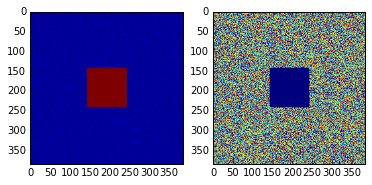

In [6]:
init_prb_flag = False  #False to load a pre-existing array
init_prb = probe
init_prbFile = inDir + 'prb_init.npy'
init_prb = np.load(init_prbFile)

plt.subplot(1,2,1)
plt.imshow(abs(init_prb))
plt.subplot(1,2,2)
plt.imshow(np.angle(init_prb))

Load a file with a sequence of the scan x-y points and shift them into the positive plane: 

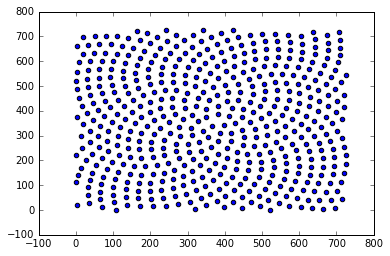

In [7]:
scanFile   = inDir + 'scan.npy'
points  = np.load(scanFile)

X = points[0] # [-363, 362]
Y = points[1] # [-363, 363]

X -= min(X) 
Y -= min(Y)

# transpose X and Y for the input file
# pixel_translation = np.column_stack((X, Y, np.zeros(Y.size)))
pixel_translation = np.column_stack((Y, X, np.zeros(Y.size)))
real_translation = pixel_translation * real_pixel_size

plt.scatter(X, Y)
plt.show()

In [8]:
print min(X), max(X), min(Y), max(Y)

0.0 725.0 0.0 726.0


Load the object file:

In [9]:
objectFile = inDir + 'object.npy'
object = np.load(objectFile) # (1170, 1172)

nx_obj = max(X) - min(X) + probe.shape[0] + 10
ny_obj = max(Y) - min(Y) + probe.shape[1] + 10

nx_obj = nx_obj + np.mod(nx_obj, 2)
ny_obj = ny_obj + np.mod(ny_obj, 2)

# print nx_obj, ny_obj, 

print object.shape[0], object.shape[1], nx_obj, ny_obj

1170 1172 1120.0 1120.0


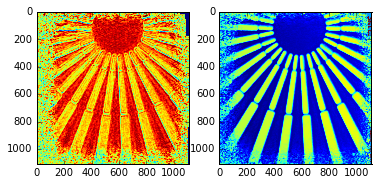

In [10]:
obj_min_x = 0
obj_max_x = int(max(X) - min(X)) + det_side

obj_min_y = object.shape[1] - (int(max(Y) - min(Y)) + det_side)
obj_max_y = object.shape[1]

# object = object[0: object.shape[0] - 61, 62: object.shape[1]]
object = object[obj_min_x: obj_max_x, obj_min_y: obj_max_y]

plt.subplot(1,2,1)
plt.imshow(abs(object))
plt.subplot(1,2,2)
plt.imshow(np.angle(object))

In [11]:
object.shape

(1109, 1110)

Define the initial object:

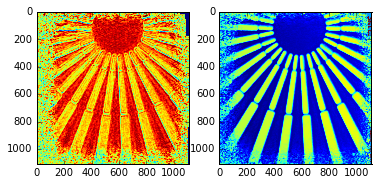

In [11]:
init_obj_flag = False  #False to load a pre-existing array
init_obj = object
# init_objFile = inDir + 'obj_init.npy'
# init_obj = np.load(init_objFile)

init_obj = init_obj[0: object.shape[0], 0: object.shape[1]]

plt.subplot(1,2,1)
plt.imshow(abs(init_obj))
plt.subplot(1,2,2)
plt.imshow(np.angle(init_obj))

Now we can generate the detector frames from scan, object, and probe:

In [12]:
nframes = X.size

objFrames = np.empty((nframes,det_side,det_side), dtype = complex)
frames = np.empty((nframes,det_side,det_side))

for i in range(0,nframes):
    ix = int(X[i])
    iy = int(Y[i])
    objFrames[i] = object[ ix : ix + det_side, iy : iy + det_side]
    frames[i] = np.abs(np.fft.fftshift(np.fft.fft2(probe*objFrames[i])))**2
    frames[i] = frames[i]/(det_side*det_side)

Create the output file:

In [13]:
f = h5py.File(outFile, "w")
f.create_dataset("cxi_version",data=140)
entry_1 = f.create_group("entry_1")

# 1. sample_1: name, geometry_1

sample_1   = entry_1.create_group("sample_1")

# 1.1 geometry_1: translation:

geometry_1 = sample_1.create_group("geometry_1")
geometry_1.create_dataset("translation", data=real_translation) # in meters

# 2. instrument_1: detector_1, source_1, data_1

instrument_1 = entry_1.create_group("instrument_1")

# 2.1 detector_1: distance, corner_position, x_pixel_size, y_pixel_size
# translation, data and axes, initial image

detector_1 = instrument_1.create_group("detector_1")
detector_1.create_dataset("distance", data=distance) # in meters
detector_1.create_dataset("corner_position", data=corner_pos) # in meters
detector_1.create_dataset("x_pixel_size", data=pixel_size) # in meters
detector_1.create_dataset("y_pixel_size", data=pixel_size) # in meters

detector_1["translation"] = h5py.SoftLink('/entry_1/sample_1/geometry_1/translation')

data = detector_1.create_dataset("data",data=frames)
data.attrs['axes'] = "translation:y:x"

detector_1.create_dataset("solution", data=object)

if(not init_obj_flag):
    detector_1.create_dataset("initial_image",data=init_obj)

# 2.2 source_1: energy

source_1 = instrument_1.create_group("source_1")
source_1.create_dataset("energy", data=energy) # in J

if(not init_prb_flag):
    source_1.create_dataset("probe",data=init_prb)

# 2.3 data_1: data, translationcd ..

data_1 = entry_1.create_group("data_1")

data_1["data"] = h5py.SoftLink('/entry_1/instrument_1/detector_1/data')
data_1["translation"] = h5py.SoftLink('/entry_1/sample_1/geometry_1/translation')

f.close()

In [9]:
# Try to reconstruct with
# sharp-nsls2.bin  -o 1 -i 100  e1.cxi
# show.py